# Understanding the Limitations of Antibody Langauage Models through Practical Examples

So far we have covered the basics of using antibody language models to encode sequences, and looked at some practival examples of how these encodings may be applied. 
In this exercise, we will look at the limitations of these models by using specific examples where there are narrow use cases or questionable results. 

Using these exercises, we will consider:
- Why do these limitations exist?
- What do these limitations tell us about the model?
- How these limitations can be overcome




In [1]:
##Imports##
import sys
sys.path.append('/home/james/L2D_material/')
import abYspacer
from Bio import SeqIO
import matplotlib.pyplot as plt

##Models##
from iglm import IgLM
import ablang


##Initialize models##
heavy_ablang = ablang.pretrained("heavy")
heavy_ablang.freeze()
light_ablang = ablang.pretrained("light")
light_ablang.freeze()
iglm = IgLM()

/home/james/miniconda3/envs/L2D/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###Functions###
def hamming_distance(seq1, seq2):
    #Calculate the difference between two sequences#
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

def average_distance(sequences):
    #Calculate the average distance between sequences#
    if not sequences:
        raise ValueError("Input list of sequences is empty")

    seq_length = len(sequences[0])
    total_distance = 0

    for i in range(len(sequences)):
        for j in range(i + 1, len(sequences)):
            if len(sequences[i]) != seq_length or len(sequences[j]) != seq_length:
                raise ValueError("All sequences must have the same length")

            total_distance += hamming_distance(sequences[i], sequences[j])
    if len(sequences) == 1:
        return 0
    if len(sequences) == 2:
        num_pairs = 1
    else:
        num_pairs = len(sequences) * (len(sequences) - 1) / 2
    average_distance = total_distance / num_pairs

    return average_distance

def bin_strings_by_length(strings):
    bins = {}

    for string in strings:
        length = len(string)
        if length in bins:
            bins[length].append(string)
        else:
            bins[length] = [string]

    return bins


## Using Models to Fill in Multiple Missing Residues

To start, we will look at how these models fill in sequences with multiple missing residues. We have taken some data from Rajan et al 2018 where NGS sequencing was used to collect immune repertoire data.
However, as you can see there are many sequences with missing residues. Using our previous understanding of how the models work:
- What do you think the model will do with these sequences?


In [3]:
##Filling in sequences with many missing residues###

Heavy_sequences = []
Light_sequences = []


for record in SeqIO.parse("/home/james/L2D_material/Data/rajan_Donor_cleaned.faa", "fasta"):
   if record.id.endswith("1"):
       Heavy_sequences.append(str(record.seq))
   elif record.id.endswith("2"):
       Light_sequences.append(str(record.seq))
       
##Check the first 10 sequences##
print(Heavy_sequences[0:10])
print(Light_sequences[0:10])

['**************************GGSI****SR*YWSWKRQPTGKGMEGIGYIYYS***GSTNYNTYLK*SRVTIPVETSKNQFSLKLSSVTAADTAVYYCARGRYYGSGSYYPEPQAFDYWGRGTTVTVS', '****************************KL****KSKERKWV*KANGKGLERMGWMNHN**SGNTGYAKKCQ*GRVTMTRKTSKRKAYMEMSRMRSEDTAVYYCARGLGSSWYSYYYYYYGMDVWGQGTTVTVS', '**************************G*N*****TGYNKNWVRQAPGQGQEWMGRINPN**RGGTDYAQKFQ*GRVTMTRDTSISTAYMELSRLRSGDTAVYYCARDHDKTGSSTAGYYYMDVWGKGTLVTVS', '*********************TCTDNGVSI****SS*YWSWSRQRPGKGLEWNGYIYYS***GSTNYNPYIK*RRVTI*VDTSKNQFSMKLSSVTAADTAVYYCARGPGRRGYSYGSDYWGQGTTVTVS', '*******************KVSCKASGYTF****NGYYMHWVRQATGQGLEWMRRINPN**SGGTNYAQKFQ*GRVTMTRDTSVSTAYMELSRLRSDDTAVYYCARDPRDYYYMDVWGKGTMVTVS', '*****************************IS**SGGYYWSWISKHPGKGLEWIG*IYYS***GRTYYNPSHK*SRVKISVEKSKNKYSRKQSSVTVADTAVYYCARADSLAVAVQRHYYYYGMDVWGQGTMVTVS', '**************************GYNF****TR*GNRRERQAPGQGKERMGRSNPN**SGGTNDAQKFQ*GRVTMTRDT*ISTA*KKLRRMRSDDTAVYYCARVARSAAIWGLDYYGVDVWGQGTLVTVS', '*************************SGYTF****NSYYMHWVRQAA

In [4]:
##Restore sequences using AbLang##
restored_heavy_seq = heavy_ablang(Heavy_sequences, mode='restore')
restored_light_seq = light_ablang(Light_sequences, mode='restore')
print(restored_heavy_seq[0:10])
print(restored_light_seq[0:10])

['GLLSSPELLLLLTTSGGTSSSSSSSWGGSISSSSSRYYWSWKRQPTGKGMEGIGYIYYSGSSGSTNYNTYLKLSRVTIPVETSKNQFSLKLSSVTAADTAVYYCARGRYYGSGSYYPEPQAFDYWGRGTTVTVS'
 'GQEELQGLKLLGTGGGGSSGFTFSDMHVKLVRQAKSKERKWVHKANGKGLERMGWMNHNSGSGNTGYAKKCQKGRVTMTRKTSKRKAYMEMSRMRSEDTAVYYCARGLGSSWYSYYYYYYGMDVWGQGTTVTVS'
 'QQQKKQGSGRKGKKKSGSSGSTGTAYGVNWVYTFTGYNKNWVRQAPGQGQEWMGRINPNNPRGGTDYAQKFQQGRVTMTRDTSISTAYMELSRLRSGDTAVYYCARDHDKTGSSTAGYYYMDVWGKGTLVTVS'
 'GLKSLEESLLLLTTSGGSSSLTCTDNGVSISSSSSSYYWSWSRQRPGKGLEWNGYIYYSGSSGSTNYNPYIKSRRVTISVDTSKNQFSMKLSSVTAADTAVYYCARGPGRRGYSYGSDYWGQGTTVTVS'
 'QQQGGQGVGGGGKSKGSSCKVSCKASGYTFTFTFNGYYMHWVRQATGQGLEWMRRINPNSPSGGTNYAQKFQQGRVTMTRDTSVSTAYMELSRLRSDDTAVYYCARDPRDYYYMDVWGKGTMVTVS'
 'GLLLQEESLLLLTTSGGTSSSSGGSSWSSISISSGGYYWSWISKHPGKGLEWIGYIYYSGYSGRTYYNPSHKKSRVKISVEKSKNKYSRKQSSVTVADTAVYYCARADSLAVAVQRHYYYYGMDVWGQGTMVTVS'
 'QQQEQQERKREVKKKGSSKKLTKTATGYNFTWSFTRYGNRRERQAPGQGKERMGRSNPNSNSGGTNDAQKFQQGRVTMTRDTSISTAYKKLRRMRSDDTAVYYCARVARSAAIWGLDYYGVDVWGQGTLVTVS'
 'QQQPPPGGGRGGKSASGSSGGSYKASGYTFTFTFNSYYMHWVRQAA


- What do you notice about the restored sequences? Hint:List the sequences with missing residues alongside the sequences with restored residues
- Why do you think it has taken this approach? 
- Where do you think the most crucial residues to get correct are? Do you think this approach is appropriate?
Task: Use the likelihood function to find out if this is the approach the model has taken


##  Using Generative Models to Generate Diversity in Sequences

Another practical use of these models in industry is to take an existing antibody sequence and apply mutations to generate diversity in order to screen for candidates. 
To take this example to the next step, we will use the model to generate sequences from scratch using a starting prompt. We will look at how diverse those sequences are from each other, and how reproducible this approach is.



In [5]:
parent_sequence = "EVQLVESGGGLVQPGGSLRLSCAASGFNIKEYYMHWVRQAPGKGLEWVGLIDPEQGNTIYDPKFQDRATISADNSKNTAYLQMNSLRAEDTAVYYCARDTAAYFDYWGQGTLVTVS"
chain_token = "[HEAVY]"
species_token = "[HUMAN]"
infill_range = (98, 106)
num_seqs = 100

generated_seqs = iglm.infill(
   parent_sequence,
   chain_token,
   species_token,
   infill_range=infill_range,
   num_to_generate=num_seqs,
)
print(generated_seqs)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 18.73it/s]

['EVQLVESGGGLVQPGGSLRLSCAASGFNIKEYYMHWVRQAPGKGLEWVGLIDPEQGNTIYDPKFQDRATISADNSKNTAYLQMNSLRAEDTAVYYCARANFFVVAAYFDYWGQGTLVTVS', 'EVQLVESGGGLVQPGGSLRLSCAASGFNIKEYYMHWVRQAPGKGLEWVGLIDPEQGNTIYDPKFQDRATISADNSKNTAYLQMNSLRAEDTAVYYCARDKQWRSDYWGQGTLVTVS', 'EVQLVESGGGLVQPGGSLRLSCAASGFNIKEYYMHWVRQAPGKGLEWVGLIDPEQGNTIYDPKFQDRATISADNSKNTAYLQMNSLRAEDTAVYYCARERDGYNYYFDYWGQGTLVTVS', 'EVQLVESGGGLVQPGGSLRLSCAASGFNIKEYYMHWVRQAPGKGLEWVGLIDPEQGNTIYDPKFQDRATISADNSKNTAYLQMNSLRAEDTAVYYCAREPPNGWGIDHWGQGTLVTVS', 'EVQLVESGGGLVQPGGSLRLSCAASGFNIKEYYMHWVRQAPGKGLEWVGLIDPEQGNTIYDPKFQDRATISADNSKNTAYLQMNSLRAEDTAVYYCAREMYFYDSYYGSYPFDYWGQGTLVTVS', 'EVQLVESGGGLVQPGGSLRLSCAASGFNIKEYYMHWVRQAPGKGLEWVGLIDPEQGNTIYDPKFQDRATISADNSKNTAYLQMNSLRAEDTAVYYCARDRYCSGNGCYSDYWGQGTLVTVS', 'EVQLVESGGGLVQPGGSLRLSCAASGFNIKEYYMHWVRQAPGKGLEWVGLIDPEQGNTIYDPKFQDRATISADNSKNTAYLQMNSLRAEDTAVYYCARSTTPARPWNLDNWGQGTLVTVS', 'EVQLVESGGGLVQPGGSLRLSCAASGFNIKEYYMHWVRQAPGKGLEWVGLIDPEQGNTIYDPKFQDRATISADNSKNTAYLQMNSLRAEDTAVYYCARSRYFDWLLYWWGQGTLVTVS', 'EVQLVESGGG

OK then, let's take a look at the sequences we've generated by comparing them to the parent sequence

In [6]:
Hamming_distances = []
for i in generated_seqs:
    Hamming_distances.append(hamming_distance(parent_sequence, i))
print(Hamming_distances)
print(sum(Hamming_distances)/len(Hamming_distances))

[18, 5, 15, 16, 15, 17, 17, 16, 15, 3, 16, 17, 15, 18, 18, 18, 15, 18, 15, 18, 18, 17, 18, 15, 18, 17, 17, 16, 17, 16, 15, 18, 18, 16, 16, 15, 15, 15, 15, 16, 18, 17, 15, 17, 18, 15, 15, 17, 14, 17, 16, 16, 18, 17, 17, 17, 17, 15, 16, 17, 16, 17, 17, 17, 17, 18, 16, 16, 18, 16, 17, 17, 4, 17, 16, 14, 17, 17, 17, 15, 16, 18, 17, 13, 18, 18, 16, 17, 17, 17, 18, 17, 16, 14, 15, 17, 18, 16, 16, 18]
16.13


So from the looks of the Hamming distances between sequences, most of them have been edited far more than just the infilled range, with a few that have hardly been changed at all.

Questions:
- The infill-range specified ranges from residues 98 to 106. Why do you think this range was chosen? Hint: think about the context of antibody binding
- What is the average distance of the sequences from the parent sequence?
- What is the average distance of the generated sequences from each other? Hint: Use one of the functions listed above
- If the num_seqs variable was increased, how do you think this would affect the average distance?
- How would you expect this method to compare to simply masking out the same region in another parent sequence? Run the kernel below to find out.


In [7]:
##Filling in masked residues of CDRH3##
seqs = ['EVQLVESGPGLVQPGKSLRLSCVASGFTFSGYGMHWVRQAPGKGLEWIALIIYDESNKYYADSVKGRFTISRDNSKNTLYLQMSSLRAEDTAVFYCAR*****WGQGTLVTVSS']

restored_seq = heavy_ablang(seqs, mode='restore')
print(restored_seq)

restored_seq = heavy_ablang(seqs, mode='restore')
print(restored_seq)


['EVQLVESGPGLVQPGKSLRLSCVASGFTFSGYGMHWVRQAPGKGLEWIALIIYDESNKYYADSVKGRFTISRDNSKNTLYLQMSSLRAEDTAVFYCARDGGDYWGQGTLVTVSS']
['EVQLVESGPGLVQPGKSLRLSCVASGFTFSGYGMHWVRQAPGKGLEWIALIIYDESNKYYADSVKGRFTISRDNSKNTLYLQMSSLRAEDTAVFYCARDGGDYWGQGTLVTVSS']


## Using Genertive Models to Design Sequences using a Prompt Sequences
Taking the above example a step further, we can, in principle, generate a whole host of diversity from a prompt sequence using IgLM. We will examine these sequences and if they follow the expected patterns seen in antibody sequences

In [8]:
##Generating sequences from scratch##

prompt_sequence = "EVQ"
chain_token = "[HEAVY]"
species_token = "[HUMAN]"
num_seqs = 100

generated_seqs = iglm.generate(
    chain_token,
    species_token,
    prompt_sequence=prompt_sequence,
    num_to_generate=num_seqs,
)

100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


In [9]:
###Bin sequences by length###


binned_gen_sequences = bin_strings_by_length(generated_seqs)

for i in list(binned_gen_sequences.keys()):
    print(i, len(binned_gen_sequences.get(i)))
    print(average_distance(binned_gen_sequences.get(i)))


131 1
0
127 4
68.5
122 10
54.62222222222222
124 9
50.111111111111114
121 13
47.48717948717949
117 9
46.916666666666664
116 4
20.666666666666668
128 5
32.0
118 8
31.678571428571427
119 4
53.833333333333336
126 4
62.5
120 10
45.08888888888889
123 7
39.38095238095238
125 4
47.5
133 1
0
114 1
0
129 2
26.0
115 2
62.0
113 1
0
112 1
0


In [10]:
generated_seqs2 = iglm.generate(
   chain_token,
   species_token,
   prompt_sequence=prompt_sequence,
   num_to_generate=num_seqs,
)

if generated_seqs == generated_seqs2:
   print("The same sequences were generated")
else:
   count = 0
   for i in generated_seqs:
       if i in generated_seqs2:
           count +=1
       
   print(f"{count} sequences were the same out of 100")


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]

0 sequences were the same out of 100


In [11]:
all_generated_positions = {}
for i in generated_seqs:
    #print(i)
    Aligned_seqs = abYspacer.get_spaced_sequence(str(i))
    for j in list(Aligned_seqs.keys()):
        if j in all_generated_positions.keys():
            all_generated_positions[j].append(Aligned_seqs.get(j))
        else:
            all_generated_positions[j] = [Aligned_seqs.get(j)]



We can check where the most diversity was generated by aligning the sequences with an antibody numbering scheme and looking at the conservation of each position.


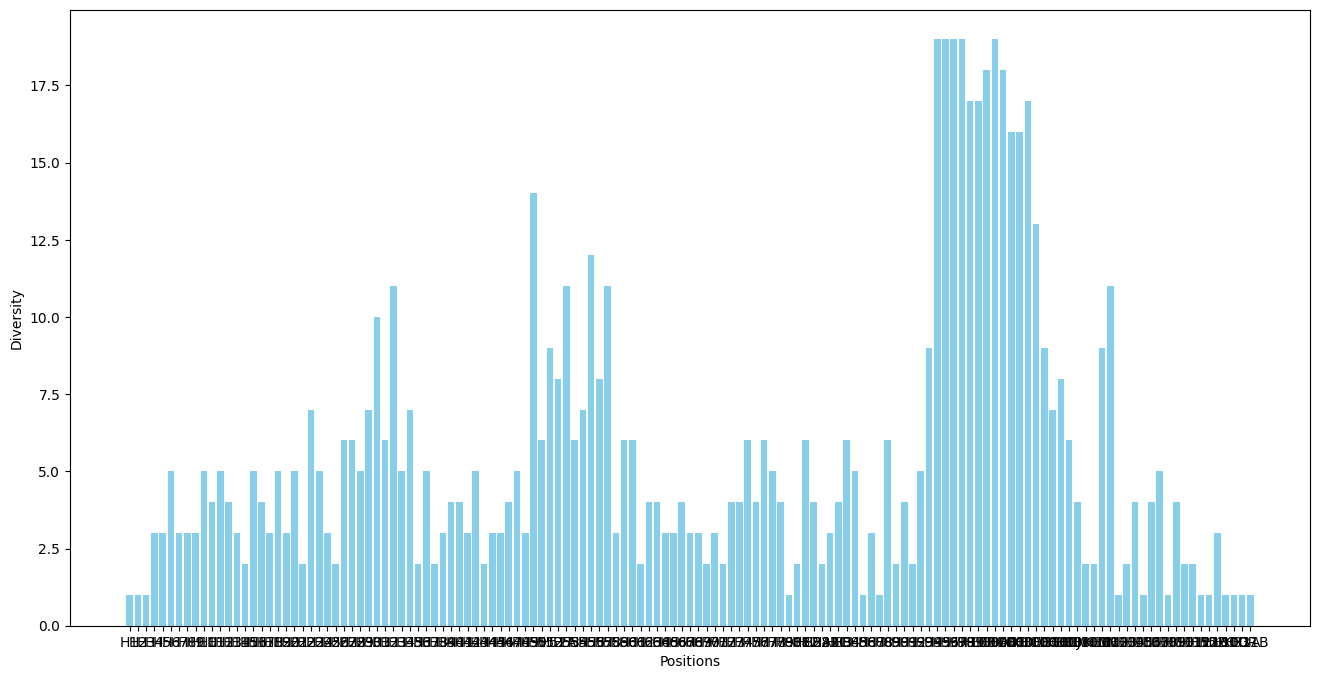

In [15]:
Heavy_sorter = ['H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23','H24','H25','H26','H27','H28','H29','H30','H31','H31A','H31B','H32','H33','H34','H35','H36','H37','H38','H39','H40','H41','H42','H43','H44','H45','H46','H47','H48','H49','H50','H51','H52','H52A','H52B','H52C','H53','H54','H55','H56','H57','H58','H59','H60','H61','H62','H63','H64','H65','H66','H67','H68','H69','H70','H71','H72','H73','H74','H75','H76','H77','H78','H79','H80','H81','H82','H82A','H82B','H82C','H83','H84','H85','H86','H87','H88','H89','H90','H91','H92','H93','H94','H95','H96','H97','H98','H99','H100','H100A','H100B','H100C','H100D','H100E','H100F','H100G','H100H','H100I','H100J','H100K','H100L','H100M','H100N','H100O','H100P','H100Q','H100R','H101','H102','H103','H104','H105','H106','H107','H108','H109','H110','H111','H112','H113']
sorted(all_generated_positions.keys(), key=lambda x: Heavy_sorter.index(x))
new_list = [len(set(x)) for x in list( all_generated_positions.values())]
plt.figure(figsize=(16, 8))
plt.bar(list(all_generated_positions.keys()), new_list, color='skyblue')
plt.xlabel('Positions')
plt.ylabel('Diversity')
#plt.title('Bar Plot Example')

# Display the plot
plt.show()



- Where do you see the most diversity was generated?
- What is the importance of this region where the most diversity was generated?
- What do you think are the advantages and disadvantages of this approach?
- How might this approach compare to simply filling in masked residues where you would expect the same diversity?
- Test this hypothesis by running the following 


## End of Series Exercises

Complete the following tasks
- Generate 1000 heavy and 1000 light sequences using the IgLM using the starting sequences "QVQ" and "DIM", consider these sequences to be paired if they share the same index
- Encode these sequences with the AbLang language models and flatten them
- Prepare the 1000 human antibody sequences previously encoded with AbLang 
- Using the machine learning classifiers and some you have found from your reading, train a model that may be able to detect IgLM-generated sequences
- Can this prediction be improved on by any particular feature selection or elimination?

Complete the following tasks
- Encode the completed sequences from the Rajan dataset
- Perform a dimensionality reduction (PCA or t-SNE)
- How do these kinds of encodings compare to the previous dimensionality reduction performed on the human sequences?


Complete the following tasks
- Use IgLM to generate 10 heavy chains with substiduted CDRH3 using the prompt sequence
- Pair those sequences with this given light chain
- Use IgFold to generate structures for each of these sequences and calculate the average RMSD between them


## End Remarks

From the previous series of worksheets, you should have gained an understanding in how these models are trained, how they could be used, but also where they may fall short of expectations. We have learned that these models can be good at filling in a missing residue in a sequence, however, in a more generative setting, they call many repeated residues which are not found in nature, making them unsuitable for antibody design. However, due to the relatively limited pool of training data available, and exisitng biases in terms of germlines avialble, language models trained on antibodies have a tendency to regress to the mean. their limitations do not mean they are not useful, however, it requires careful consideration of their context, and an understanding what the encodings are telling us.